In [ ]:
#pip install tensorflow keras pandas matplotlib opencv-python scikit-learn


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


In [ ]:
from google.colab import files
files.upload()  # ini buat upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "vishrutiparekh",\r\n  "key": "9fc3aa809c94895cbbe82ce4af06c1bd"\r\n}\r\n'}

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.74G/5.76G [00:58<00:00, 104MB/s]
100% 5.76G/5.76G [00:58<00:00, 106MB/s]


In [ ]:
!unzip cassava-leaf-disease-classification.zip -d /content/cassava_data


Streaming output truncated to the last 5000 lines.
  inflating: /content/cassava_data/train_images/3954487465.jpg  
  inflating: /content/cassava_data/train_images/3954910918.jpg  
  inflating: /content/cassava_data/train_images/3955391972.jpg  
  inflating: /content/cassava_data/train_images/3955442838.jpg  
  inflating: /content/cassava_data/train_images/3955739563.jpg  
  inflating: /content/cassava_data/train_images/3955931830.jpg  
  inflating: /content/cassava_data/train_images/3955972139.jpg  
  inflating: /content/cassava_data/train_images/3956075690.jpg  
  inflating: /content/cassava_data/train_images/3956077728.jpg  
  inflating: /content/cassava_data/train_images/3956155774.jpg  
  inflating: /content/cassava_data/train_images/3956271103.jpg  
  inflating: /content/cassava_data/train_images/3956372146.jpg  
  inflating: /content/cassava_data/train_images/3956407201.jpg  
  inflating: /content/cassava_data/train_images/3956550570.jpg  
  inflating: /content/cassava_data/trai

In [ ]:
df = pd.read_csv('/content/cassava_data/train.csv')


In [ ]:
print(df.head())
print(df['label'].value_counts())


         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64


**Load Images and Labels:**

In [ ]:
import os

# List contents of the directory
print(os.listdir('/content/cassava_data/train_images'))


['207668947.jpg', '2149765362.jpg', '3362457506.jpg', '2635687747.jpg', '895206716.jpg', '1461335818.jpg', '2269945499.jpg', '58720038.jpg', '660261179.jpg', '437931902.jpg', '2816088621.jpg', '1351445240.jpg', '3511444147.jpg', '173849826.jpg', '4046239145.jpg', '1398447903.jpg', '1677019415.jpg', '1620023854.jpg', '2345503598.jpg', '1624580117.jpg', '266634064.jpg', '1924411392.jpg', '1700921498.jpg', '1769605391.jpg', '726377415.jpg', '1386157120.jpg', '1339614738.jpg', '3533493433.jpg', '1681477511.jpg', '4108844904.jpg', '770763357.jpg', '1579515539.jpg', '3015865216.jpg', '1407007212.jpg', '1299200628.jpg', '3240850732.jpg', '2856023827.jpg', '1882441539.jpg', '1557930579.jpg', '2722184937.jpg', '1497799028.jpg', '1921138686.jpg', '456647345.jpg', '3909952620.jpg', '226962956.jpg', '3276257158.jpg', '2586069156.jpg', '3272245508.jpg', '360723691.jpg', '1358224095.jpg', '2401066705.jpg', '391233797.jpg', '1859785937.jpg', '2823421970.jpg', '913294875.jpg', '3527494805.jpg', '70734

In [ ]:
import os
import shutil
import pandas as pd

# Define the base directory where images are located
base_dir = '/content/cassava_data/train_images'
csv_file_path = '/content/cassava_data/train.csv'  # Path to your CSV file

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Print the DataFrame to check its structure
print("DataFrame structure:")
print(df.head())  # Display the first few rows
print("\nDataFrame types:")
print(df.dtypes)  # Display the data types of each column

# Ensure labels are strings
df['label'] = df['label'].astype(str)

# List of class names (optional, for verification)
CLASSES = df['label'].unique().tolist()

# Print the class names for verification
print("\nClass Names:")
print(CLASSES)

# Create class directories if they don't exist
for class_name in CLASSES:
    # Ensure class_name is a string
    if isinstance(class_name, str):
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)
    else:
        print(f"Skipping non-string class name: {class_name}")

# Move images to their respective class directories
for _, row in df.iterrows():
    image_name = row['image_id']
    class_name = row['label']

    source_path = os.path.join(base_dir, image_name)  # Path to the original image
    dest_path = os.path.join(base_dir, class_name, image_name)  # Path to the new location

    if os.path.exists(source_path):  # Check if the source image exists
        shutil.move(source_path, dest_path)  # Move the image
    else:
        print(f"Image not found: {source_path}")  # Log if the image is missing


DataFrame structure:
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

DataFrame types:
image_id    object
label        int64
dtype: object

Class Names:
['0', '3', '1', '2', '4']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    '/content/cassava_data/train_images',
    target_size=(224, 224),   # Resize images
    batch_size=32,
    class_mode='categorical',  # Use categorical for multi-class classification
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/cassava_data/train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',   # Use categorical for validation as well
    subset='validation'
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the base model using VGG16
base_model = keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming 5 classes for cassava diseases
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 17120 images belonging to 5 classes.
Found 4277 images belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the base model
base_model = keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming 5 classes for cassava diseases
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10  # Adjust the number of epochs as needed
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


535/535 ━━━━━━━━━━━━━━━━━━━━ 341s 612ms/step - accuracy: 0.6569 - loss: 0.9653 - val_accuracy: 0.6932 - val_loss: 0.8330
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 298s 552ms/step - accuracy: 0.7011 - loss: 0.8267 - val_accuracy: 0.7028 - val_loss: 0.7974
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 299s 555ms/step - accuracy: 0.7132 - loss: 0.7830 - val_accuracy: 0.6949 - val_loss: 0.8229
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 322s 553ms/step - accuracy: 0.7103 - loss: 0.7833 - val_accuracy: 0.7180 - val_loss: 0.7882
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 298s 553ms/step - accuracy: 0.7283 - loss: 0.7610 - val_accuracy: 0.7143 - val_loss: 0.8041
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 322s 552ms/step - accuracy: 0.7270 - loss: 0.7488 - val_accuracy: 0.7145 - val_loss: 0.7785
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 346s 595ms/step - accuracy: 0.7324 - loss: 0.7323 - val_accuracy: 0.7105 - val_loss: 0.7878
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 360s 556ms/step - accuracy: 0.7325 - loss: 0.72

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


134/134 ━━━━━━━━━━━━━━━━━━━━ 61s 452ms/step - accuracy: 0.7326 - loss: 0.7466
Validation Accuracy: 72.48%


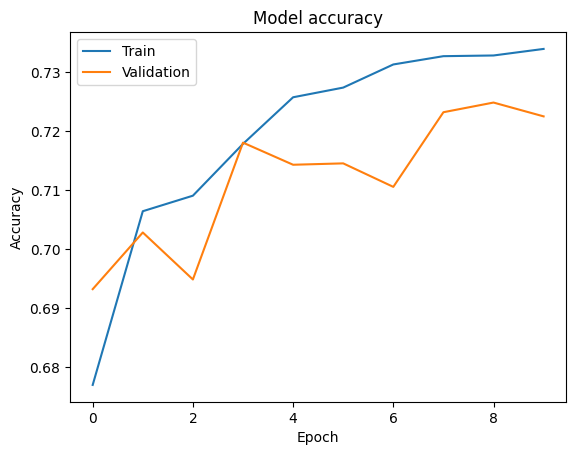

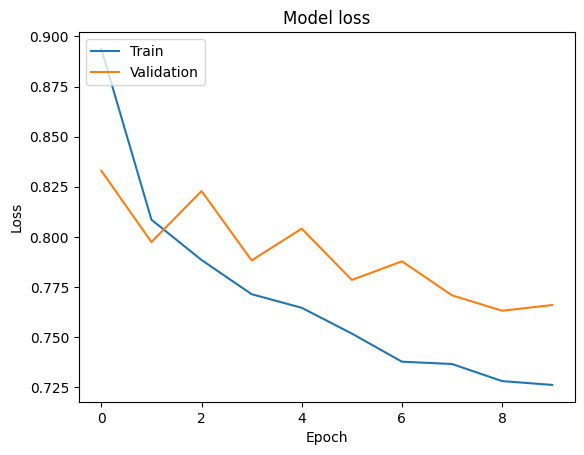

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


134/134 ━━━━━━━━━━━━━━━━━━━━ 68s 470ms/step


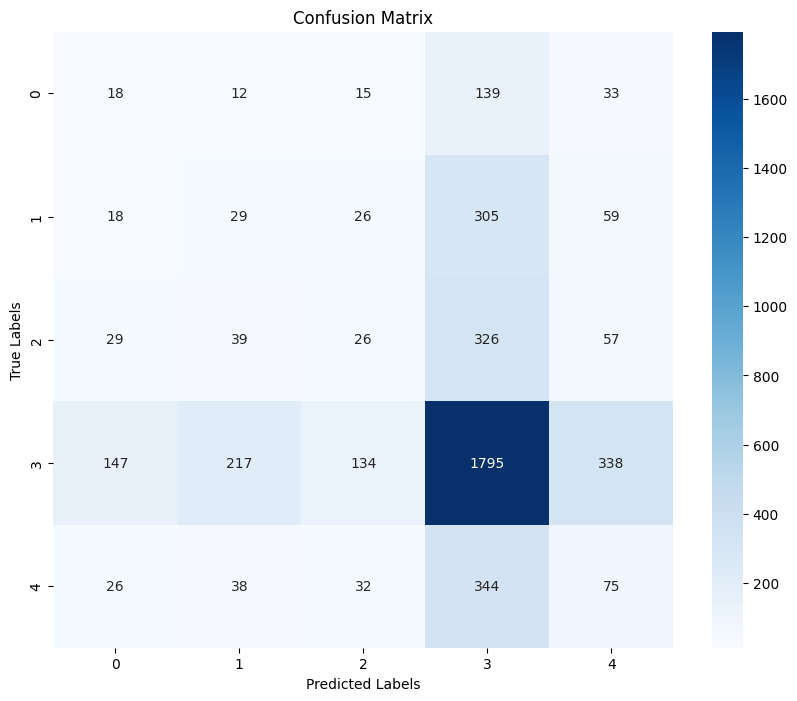

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming validation_generator is your validation data generator
# Get true labels and predictions
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get class names from the generator
class_names = list(validation_generator.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
print(os.listdir('/content/cassava_data/train_images'))


['0', '4', '3', '1', '2']


In [ ]:
import os

# Example: List images within the '0' class folder
class_folder = '/content/cassava_data/train_images/0'
image_files = os.listdir(class_folder)
print(image_files)  # List all image files in the '0' folder


['1299200628.jpg', '785146800.jpg', '3944841972.jpg', '4288369732.jpg', '313266547.jpg', '1442345924.jpg', '3986748411.jpg', '2559696276.jpg', '2717138442.jpg', '1700812370.jpg', '532081653.jpg', '1127286868.jpg', '2998136552.jpg', '3645775098.jpg', '478036306.jpg', '822120250.jpg', '798023657.jpg', '1535057791.jpg', '1497853421.jpg', '1033403106.jpg', '2044199243.jpg', '1166973570.jpg', '3184759653.jpg', '1383020993.jpg', '657031133.jpg', '2562484924.jpg', '2308841380.jpg', '2028087473.jpg', '27094452.jpg', '3734403071.jpg', '2455854003.jpg', '3413149507.jpg', '3372358709.jpg', '3739021598.jpg', '3249336274.jpg', '291050311.jpg', '2174393587.jpg', '142362483.jpg', '324248837.jpg', '886449535.jpg', '3327250048.jpg', '3889664923.jpg', '1000015157.jpg', '2642869227.jpg', '211163536.jpg', '4059009090.jpg', '685003567.jpg', '3234915269.jpg', '2478144118.jpg', '1569164715.jpg', '2593776626.jpg', '2198388199.jpg', '724195836.jpg', '1816076936.jpg', '2347718160.jpg', '2399673034.jpg', '271047

In [ ]:

# Define the path to the test images folder
test_folder = '/content/cassava_data/test_images'
image_files = os.listdir(test_folder)
print(image_files)  # List all image files in the test_images folder


['2216849948.jpg']


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = '/content/cassava_data/test_images/2216849948.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: [4]


In [ ]:
model.save('model.keras')  # Saves in the Keras format


In [ ]:
from google.colab import files
files.download('model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>